# Moneyball Project: UEFA Euro 2020 Fantasy Football
Passion project to leverage data-driven decision making for team selection in [UEFA Euro 2020 Fantasy Football](https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/overview)

## Modelling
-----------------------------
### Purpose
Project points and roi of player for matchday 1 of UEFA Euro 2020

### Author
[Christian Wibisono](https://github.com/christianwbsn)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset_md2.csv".format(DATA_DIR))

In [4]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]
test = test.drop_duplicates(subset=["player", "date"], keep="first")
test = test.reset_index(drop=True)

<ipython-input-4-3198189a0046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [5]:
train.shape

(7796, 114)

In [6]:
test.shape

(615, 114)

In [7]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018,9,6,7.0,8.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,19,1536,26,29,1484,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52,-10,9.910000e+08,38100000.0,0.1,True,False,1.0,0.823529,False,High,High
1,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018,9,6,7.0,4.0,1.0,7.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,19,1536,26,29,1484,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52,-10,9.910000e+08,38100000.0,0.1,True,False,1.0,1.750000,False,High,High
2,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018,9,9,2.0,8.5,3.0,7.0,1.0,0.0,7.0,1.0,0.0,7.0,0.000000,0.000000,0.0,90.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,18,19,1536,9,9,1580,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44,10,-1.339500e+09,-51500000.0,-2.2,True,False,1.0,0.235294,False,High,High
3,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018,9,9,2.0,4.0,1.0,2.0,0.0,0.0,7.0,1.0,0.0,7.0,0.000000,0.000000,0.0,90.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,18,19,1536,9,9,1580,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000

In [8]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_market_value', 'diff_team_mean_market_value',
       'diff_team_mean_squad_age', 'is_senior', 'is_imbalanced',
       'gap_to_potential', 'roi', 'more_likely_to_win', 'attacking_work_rate',
       'defending_work_rate'],
      dtype='object', length=114)

In [9]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'pace', 
            'dribbling', 'physic']

In [10]:
dropped_cols = ['player', 'league_name', 'date', 'year','points', 'passing',
                'roi', 'value', 'min', 'nation_position', 'defending',
                'last_md_assists', 'last_md_goals', 'prev_std_assists',
                'month', 'day', 'nation_jersey_number','team_name', 'opponent_name',
                'fantasy_points', 'prev_mean_goals', 'prev_median_min', "prev_std_goals",
                "prev_team_highest_rank" , "prev_opponent_highest_rank", "is_senior", "hth_draw"]

In [11]:
dropped_cols += fifa_col

In [12]:
def train_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)

Need to find sweet spot between player consistency and speculation (The Mavericks) --> player with high volatility of points [http://www.frontier-economics.com/uk/en/news-and-articles/articles/article-i7337-how-to-win-your-fantasy-football-league/] 
* roi -> measuring value for money (find undervalued player)
* points --> measuring player consistency

In [13]:
model_roi = RandomForestRegressor(random_state=1)
train_model(train, dropped_cols, "roi", model_roi, True)

RandomForestRegressor(random_state=1)
MAE: 0.29539206494239995
MSE: 0.1641085809070542


In [14]:
model_points = LGBMRegressor(random_state=1)
train_model(train, dropped_cols, "points", model_points, True)

LGBMRegressor(random_state=1)
MAE: 1.8196370701733595
MSE: 5.9744787096017165


## The Dream Team

In [15]:
X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))

In [16]:
def plotImp(model, X , num =20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(str(model) +' Features')
    plt.tight_layout()
    plt.show()

In [17]:
def get_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'attacking_finishing',
       'diff_team_points', 'diff_team_ranking', 'diff_team_market_value',
       'diff_team_mean_market_value', 'diff

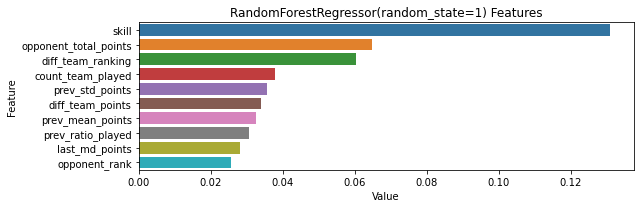

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'attacking_finishing',
       'diff_team_points', 'diff_team_ranking', 'diff_team_market_value',
       'diff_team_mean_market_value', 'diff

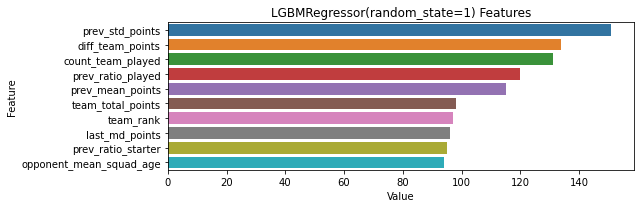

In [18]:
model_1 = get_model(train, dropped_cols, 'roi', model_roi, True)
model_2 = get_model(train, dropped_cols, 'points', model_points, True)

In [19]:
import shap
shap.initjs()

In [20]:
explainer = shap.Explainer(model_2)
shap_obj = explainer(X_test)

In [21]:
def player_to_watch(shap_obj, df, player_name):
    print("Evaluating points for: ", player_name)
    player = df[(df["player"] == player_name)][:1]
    display(player)
    shap.plots.waterfall(shap_obj[player.index[0]])

In [22]:
X_test

,skill,last_md_points,prev_mean_points,prev_mean_assists,prev_max_points,prev_std_points,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,league_rank,overall,potential,wage_eur,international_reputation,shooting,attacking_finishing,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
0,3.0,0.0,3.666667,0.000000,13.0,3.764496,0.777778,9.0,0.222222,0.000000,0.222222,28.0,NaN,NaN,NaN,0.321429,17,1570,29,1505,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,25.0,3.250000e+09,125000000.0,29.0,1.0,82.0,82.0,98000.0,3.0,77.0,75.0,65,-12,-1.482500e+09,-57000000.0,0.6,True,0.0,False,0,0,0,1,1,0,0,1,0,0
1,3.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,28.0,NaN,NaN,NaN,0.035714,4,1686,44,1441,3.0,0.0,11.0,5.0,3.0,25.4,1.250000e+10,498000000.0,27.3,2.698500e+09,103800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,-40,9.801500e+09,394200000.0,-1.9,True,NaN,True,0,0,0,1,0,0,0,0,0,0
2,3.0,0.0,1.500000,0.250000,4.0,1.732051,0.000000,4.0,0.000000,0.250000,0.000000,30.0,NaN,NaN,NaN,0.133333,29,1505,17,1570,0.0,0.0,0.0,0.0,NaN,25.0,3.250000e+09,125000000.0,25.6,1.767500e+09,68000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65,12,1.482500e+09,57000000.0,-0.6,True,NaN,False,0,0,0,1,0,0,0,0,0,0
3,1.0,0.0,0.666667,0.000000,1.0,0.577350,0.000000,3.0,0.000000,0.000000,0.000000,28.0,NaN,NaN,NaN,0.107143,17,1570,29,1505,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,25.0,3.250000e+09,125000000.0,27.0,2.0,70.0,73.0,12000.0,1.0,NaN,11.0,65,-12,-1.482500e+09,-57000000.0,0.6,True,3.0,False,0,0,1,0,0,0,1,0,0,1
4,4.0,1.0,1.000000,0.000000,1.0,NaN,0.000000,1.0,0.000000,0.000000,1.000000,27.0,NaN,NaN,NaN,0.037037,40,1458,14,1605,0.0,1.0,4.0,6.0,2.0,27.4,1.900000e+09,73100000.0,27.8,3.758000e+09,144500000.0,17.0,1.0,74.0,87.0,500.0,1.0,71.0,70.0,-147,26,-1.858000e+09,-71400000.0,-0.4,True,13.0,False,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,3.0,2.0,2.217391,0.043478,8.0,1.650249,0.913043,23.0,0.043478,0.043478,0.260870,27.0,NaN,NaN,NaN,0.851852,37,1468,2,1757,0.0,0.0,0.0,0.0,NaN,28.1,7.485000e+08,28800000.0,27.9,1.030000e+10,395400000.0,25.0,2.0,72.0,77.0,29000.0,1.0,54.0,48.0,-289,35,-9.551500e+09,-366600000.0,0.2,True,5.0,False,0,0,0,1,0,0,1,1,0,0
611,4.0,2.0,3.360000,0.080000,10.0,2.325224,0.960000,25.0,0.280000,0.080000,0.280000,27.0,NaN,NaN,NaN,0.925926,37,1468,2,1757,0.0,0.0,0.0,0.0,NaN,28.1,7.485000e+08,28800000.0,27.9,1.030000e+10,395400000.0,32.0,1.0,71.0,71.0,18000.0,2.0,71.0,71.0,-289,35,-9.551500e+09,-366600000.0,0.2,True,0.0,False,0,1,0,0,0,0,1,0,0,1
612,2.0,0.0,1.000000,0.000000,2.0,1.414214,0.500000,2.0,0.000000,0.000000,0.000000,27.0,NaN,NaN,NaN,0.074074,37,1468,2,1757,0.0,0.0,0.0,0.0,NaN,28.1,7.485000e+08,28800000.0,27.9,1.030000e+10,395400000.0,24.0,1.0,64.0,72.0,2000.0,1.0,31.0,26.0,-289,35,-9.551500e+09,-366600000.0,0.2,True,8.0,False,1,0,0,0,0,1,0,0,0,1
613,4.0,2.0,3.235294,0.058824,10.0,2.634611,0.764706,17.0,0.294118,0.058824,0.352941,28.0,NaN,NaN,NaN,0.607143,6,1648,21,1549,1.0,0.0,6.0,0.0,6.0,26.5,9.150000e+09,381300000.0,27.1,2.768000e+09,106500000.0,27.0,1.0,82.0,83.0,

In [23]:
test["predicted_roi"] = model_1.predict(X_test.fillna(0))
test["predicted_points"] = model_2.predict(X_test)

## Surfacing The Result

In [24]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [25]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [26]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [27]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [28]:
players = players[~pd.isnull(players['position'])]
players = players[players['prev_ratio_starter'] > 0.75]
players = players[players['prev_ratio_played'] > 0.55]
players = players[players['last_md_points'] > 0]
players = players[(players['more_likely_to_win']) | (players["diff_team_ranking"] < -5)]

In [29]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [30]:
players["final_score"] = players["scaled_points"] * 0.9 + players["scaled_roi"] * 0.1

In [31]:
players = players.sort_values(by=["final_score"], ascending=False)

In [32]:
players["match"] = players["team_name"] + ',' + players['opponent_name']
players["match"] = players["match"].apply(lambda x: ' '.join(sorted(x.split(","))))

In [33]:
players = players.groupby("match").head(3).reset_index()

In [53]:
col = ["player", "team_name", "opponent_name", "position", "value", "predicted_roi", "predicted_points", "final_score", "last_md_points", "prev_max_points", "prev_mean_points", "prev_std_points",'clean_sheet_consistency']

In [54]:
views = players[col]

In [55]:
views.head(50)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency
0,Romelu Lukaku,Belgium,Denmark,F,11.0,0.609800,5.754291,2.805361,10.0,13.0,7.529412,3.223307,0.470588
1,Raheem Sterling,England,Scotland,M,9.5,0.499293,5.444034,2.444172,8.0,18.0,7.000000,5.291503,0.555556
2,Hugo Lloris,France,Hungary,GK,6.0,0.926833,5.090332,2.313692,6.0,7.0,4.350000,2.323224,0.500000
3,Raphael Varane,France,Hungary,D,6.0,0.915251,4.707914,1.931828,6.0,8.0,4.040000,2.423496,0.440000
4,Harry Kane,England,Scotland,F,11.5,0.465239,4.728234,1.723122,2.0,17.0,5.333333,4.497987,0.458333
5,Kyle Walker,England,Scotland,D,5.5,0.834376,4.378063,1.566434,6.0,9.0,3.375000,2.446085,0.437500
6,Raphael Guerreiro,Portugal,Germany,D,6.5,0.738754,4.307318,1.448288,12.0,12.0,4.611111,2.681942,0.500000
7,Benjamin Pavard,France,Hungary,D,6.0,0.861081,3.900882,1.110859,6.0,9.0,3.409091,2.630573,0.363636
8,Rui Patrício,Portugal,Germany,GK,5.5,0.863170,3.896280,1.107397,7.0,7.0,4.450000,2.480980,0.550000
9,Thorgan Hazard,Belgium,Denmark,M,8.0,0.583252,4.040003,1.106452,3.0,12.0,3.809524,2.803909,0.476190


## Goalkeeper

In [56]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency
2,Hugo Lloris,France,Hungary,GK,6.0,0.926833,5.090332,2.313692,6.0,7.0,4.350000,2.323224,0.500000
8,Rui Patrício,Portugal,Germany,GK,5.5,0.863170,3.896280,1.107397,7.0,7.0,4.450000,2.480980,0.550000
10,Gianluigi Donnarumma,Italy,Switzerland,GK,5.5,0.888204,3.874027,1.098240,6.0,7.0,4.950000,1.986136,0.650000
19,Dominik Livakovic,Croatia,Czech Republic,GK,5.0,0.561843,3.072168,0.144037,2.0,7.0,3.210526,1.960129,0.263158
26,Robin Olsen,Sweden,Slovakia,GK,5.0,0.532379,2.790961,-0.147407,7.0,7.0,3.850000,2.323224,0.400000


Evaluating points for:  Hugo Lloris


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
211,Hugo Lloris,2021-06-19 15:00:00,European Championship 2020,France,Hungary,NaN,NaN,GK,2021,6,19,NaN,6.0,1.0,6.0,0.0,0.0,4.35,0.0,0.0,7.0,2.323224,0.0,0.0,90.0,1.0,20.0,0.0,0.0,0.5,29.0,NaN,NaN,NaN,0.689655,1,2,1757,37,37,1468,0.0,0.0,0.0,0.0,0.0,NaN,27.9,1.030000e+10,395400000.0,28.1,748500000.0,28800000.0,33.0,188.0,82.0,1.0,87.0,87.0,125000.0,4.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,13.0,10.0,10.0,50.0,11.0,10.0,11.0,10.0,50.0,34.0,65.0,62.0,55.0,85.0,54.0,51.0,74.0,41.0,43.0,14.0,31.0,27.0,10.0,30.0,40.0,65.0,10.0,18.0,89.0,82.0,68.0,84.0,90.0,289,-35,9.551500e+09,366600000.0,-0.2,True,True,0.0,NaN,False,Medium,Medium,0.926833,5.090332


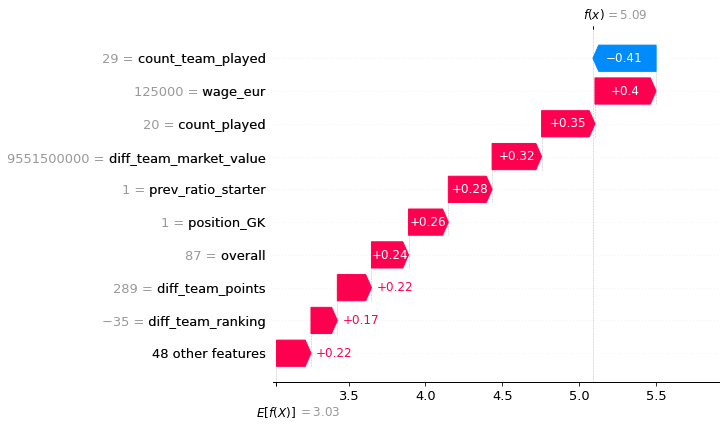

In [57]:
player_to_watch(shap_obj, test, "Hugo Lloris")

Evaluating points for:  Gianluigi Donnarumma


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
190,Gianluigi Donnarumma,2021-06-16 21:00:00,European Championship 2020,Italy,Switzerland,NaN,NaN,GK,2021,6,16,NaN,5.5,1.0,6.0,0.0,0.0,4.95,0.0,0.0,7.0,1.986136,0.0,0.0,90.0,1.0,20.0,0.0,0.0,0.65,28.0,NaN,NaN,NaN,0.714286,7,7,1642,6,13,1606,0.0,0.0,1.0,1.0,1.0,0.0,27.8,7.640000e+09,293800000.0,27.0,2.835000e+09,109000000.0,21.0,196.0,90.0,1.0,85.0,92.0,34000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,21.0,NaN,12.0,12.0,12.0,34.0,8.0,28.0,12.0,14.0,24.0,28.0,46.0,54.0,64.0,79.0,38.0,57.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,50.0,24.0,68.0,14.0,16.0,89.0,81.0,76.0,83.0,89.0,36,-6,4.805000e+09,184800000.0,0.8,False,False,7.0,NaN,False,Medium,Medium,0.888204,3.874027


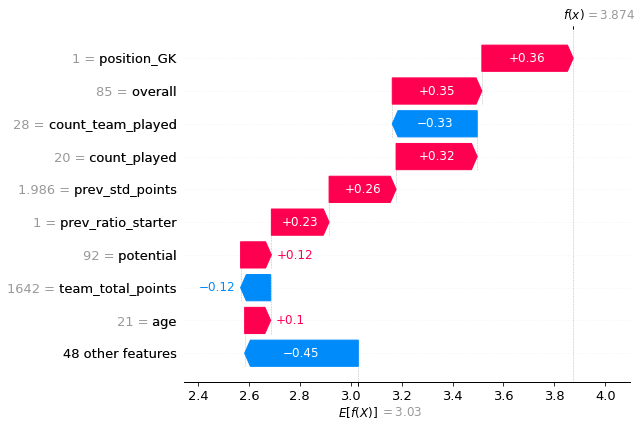

In [58]:
player_to_watch(shap_obj, test, "Gianluigi Donnarumma")

## Defender

In [59]:
views[(views["position"] == "D")].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency
3,Raphael Varane,France,Hungary,D,6.0,0.915251,4.707914,1.931828,6.0,8.0,4.040000,2.423496,0.440000
5,Kyle Walker,England,Scotland,D,5.5,0.834376,4.378063,1.566434,6.0,9.0,3.375000,2.446085,0.437500
6,Raphael Guerreiro,Portugal,Germany,D,6.5,0.738754,4.307318,1.448288,12.0,12.0,4.611111,2.681942,0.500000
7,Benjamin Pavard,France,Hungary,D,6.0,0.861081,3.900882,1.110859,6.0,9.0,3.409091,2.630573,0.363636
11,Jan Vertonghen,Belgium,Denmark,D,5.5,0.632841,3.974849,1.067596,6.0,6.0,4.578947,2.168353,0.684211
13,Leonardo Bonucci,Italy,Switzerland,D,5.5,0.775980,3.643426,0.814493,6.0,12.0,4.863636,2.677871,0.590909
16,Ben Davies,Wales,Turkey,D,5.5,0.758303,3.222639,0.391810,2.0,6.0,3.800000,2.307881,0.500000
17,Oleksandr Zinchenko,Ukraine,North Macedonia,D,5.5,0.538020,3.141201,0.199801,1.0,12.0,3.666667,3.183290,0.285714
20,Mario Fernandes,Russia,Finland,D,5.5,0.817596,2.932203,0.136397,1.0,12.0,4.421053,3.132549,0.368421
22,Mykola Matvyenko,Ukraine,North Macedonia,D,4.5,0.411586,2.971903,-0.030896,1.0,6.0,3.800000,2.512824,0.533333


Evaluating points for:  Kyle Walker


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
313,Kyle Walker,2021-06-18 21:00:00,European Championship 2020,England,Scotland,NaN,NaN,D,2021,6,18,NaN,5.5,2.0,6.0,0.0,0.0,3.375,0.0,0.0625,9.0,2.446085,0.0,0.25,90.0,0.875,16.0,0.0,0.0625,0.4375,28.0,NaN,NaN,NaN,0.571429,4,4,1686,31,44,1441,3.0,0.0,1.0,11.0,5.0,3.0,25.4,1.250000e+10,498000000.0,27.3,2.698500e+09,103800000.0,30.0,183.0,70.0,1.0,85.0,85.0,170000.0,3.0,92.0,63.0,76.0,77.0,80.0,NaN,NaN,82.0,81.0,51.0,74.0,78.0,57.0,79.0,76.0,71.0,76.0,79.0,90.0,94.0,66.0,84.0,69.0,86.0,83.0,89.0,79.0,69.0,78.0,80.0,68.0,69.0,63.0,75.0,83.0,82.0,12.0,6.0,16.0,15.0,8.0,245,-40,9.801500e+09,394200000.0,-1.9,True,True,0.0,NaN,True,High,High,0.834376,4.378063


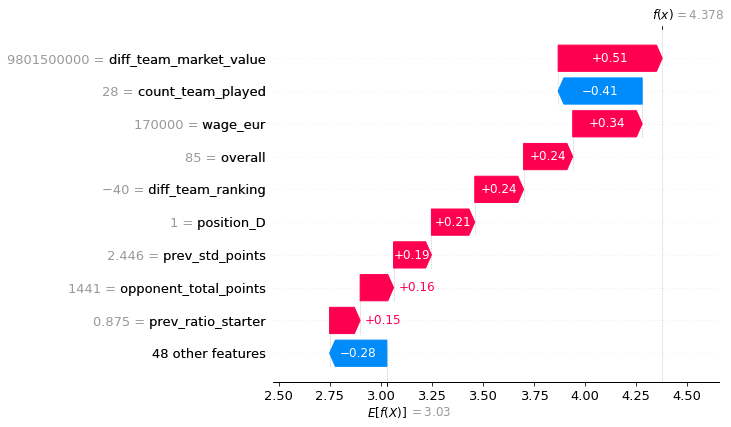

In [68]:
player_to_watch(shap_obj, test, "Kyle Walker")

Evaluating points for:  Jan Vertonghen


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
232,Jan Vertonghen,2021-06-17 18:00:00,European Championship 2020,Belgium,Denmark,NaN,NaN,D,2021,6,17,NaN,5.5,2.0,6.0,0.0,0.0,4.578947,0.0,0.0,6.0,2.168353,0.0,0.0,90.0,1.0,19.0,0.0,0.0,0.684211,28.0,0.0,6.0,3.5,0.678571,1,1,1783,9,10,1631,2.0,0.0,0.0,6.0,2.0,2.0,29.2,6.694000e+09,257500000.0,27.7,3.107000e+09,119500000.0,33.0,189.0,86.0,1.0,83.0,83.0,21000.0,3.0,58.0,62.0,72.0,71.0,85.0,LCB,5.0,78.0,70.0,54.0,78.0,77.0,52.0,70.0,66.0,70.0,73.0,77.0,55.0,61.0,56.0,82.0,60.0,80.0,83.0,72.0,79.0,66.0,84.0,85.0,56.0,66.0,66.0,81.0,85.0,86.0,6.0,10.0,9.0,12.0,7.0,152,-9,3.587000e+09,138000000.0,1.5,True,False,0.0,NaN,True,High,High,0.632841,3.974849


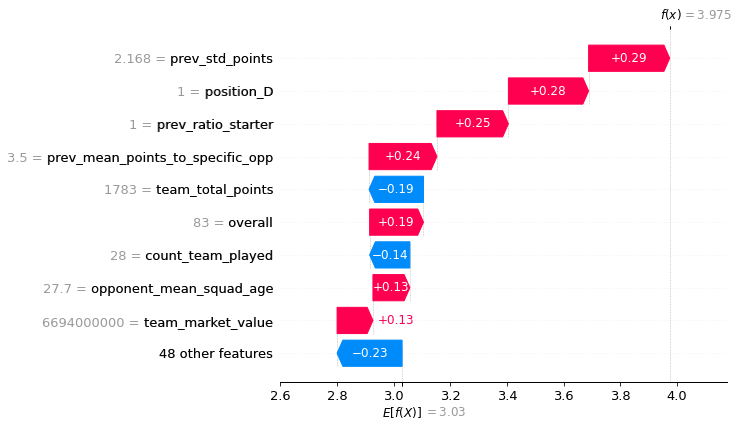

In [69]:
player_to_watch(shap_obj, test, "Jan Vertonghen")

## Midfielder

In [62]:
views[(views["position"] == "M")].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency
1,Raheem Sterling,England,Scotland,M,9.5,0.499293,5.444034,2.444172,8.0,18.0,7.000000,5.291503,0.555556
9,Thorgan Hazard,Belgium,Denmark,M,8.0,0.583252,4.040003,1.106452,3.0,12.0,3.809524,2.803909,0.476190
18,Ruslan Malinovskiy,Ukraine,North Macedonia,M,7.0,0.340415,3.224279,0.181062,5.0,13.0,3.869565,3.279473,0.304348
21,Georginio Wijnaldum,Netherlands,Austria,M,8.0,0.504761,2.942684,-0.012274,7.0,18.0,5.346154,4.516125,0.346154
29,Ivan Perisic,Croatia,Czech Republic,M,8.5,0.338806,2.584931,-0.448337,2.0,9.0,3.080000,2.448129,0.160000
31,Nicolò Barella,Italy,Switzerland,M,7.0,0.482297,2.304981,-0.650653,3.0,9.0,3.727273,2.472358,0.590909
32,Luka Modric,Croatia,Czech Republic,M,8.5,0.366016,2.280433,-0.733879,2.0,8.0,2.869565,1.961084,0.173913


Evaluating points for:  Raheem Sterling


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
472,Raheem Sterling,2021-06-18 21:00:00,European Championship 2020,England,Scotland,NaN,NaN,M,2021,6,18,NaN,9.5,3.0,8.0,1.0,0.0,7.0,0.5,0.333333,18.0,5.291503,0.894792,0.594089,90.0,1.0,18.0,0.5,0.277778,0.555556,28.0,NaN,NaN,NaN,0.642857,4,4,1686,31,44,1441,3.0,0.0,1.0,11.0,5.0,3.0,25.4,1.250000e+10,498000000.0,27.3,2.698500e+09,103800000.0,25.0,170.0,69.0,1.0,88.0,90.0,270000.0,3.0,93.0,81.0,79.0,90.0,45.0,LW,7.0,67.0,78.0,85.0,46.0,84.0,67.0,90.0,77.0,63.0,69.0,88.0,96.0,90.0,94.0,90.0,94.0,78.0,57.0,79.0,65.0,79.0,59.0,30.0,92.0,82.0,69.0,80.0,53.0,47.0,15.0,12.0,12.0,15.0,9.0,245,-40,9.801500e+09,394200000.0,-1.9,False,True,2.0,NaN,True,High,Medium,0.499293,5.444034


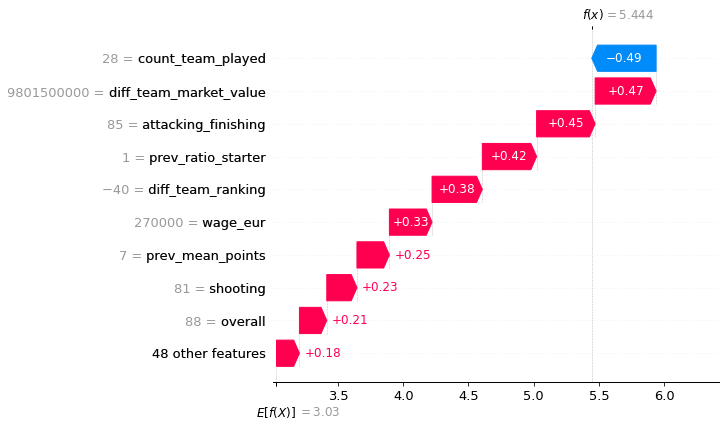

In [63]:
player_to_watch(shap_obj, test, "Raheem Sterling")

Evaluating points for:  Ruslan Malinovskiy


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
508,Ruslan Malinovskiy,2021-06-17 15:00:00,European Championship 2020,Ukraine,North Macedonia,NaN,NaN,M,2021,6,17,NaN,7.0,3.0,5.0,0.0,1.0,3.869565,0.0,0.173913,13.0,3.279473,0.540824,0.491026,90.0,0.956522,23.0,0.217391,0.130435,0.304348,26.0,NaN,NaN,NaN,0.884615,22,24,1514,62,62,1374,2.0,0.0,0.0,3.0,0.0,2.0,26.4,1.972000e+09,75800000.0,27.6,618000000.0,23800000.0,27.0,181.0,79.0,1.0,79.0,80.0,58000.0,1.0,70.0,79.0,81.0,78.0,66.0,NaN,NaN,79.0,79.0,73.0,75.0,82.0,70.0,81.0,85.0,88.0,81.0,82.0,68.0,71.0,62.0,74.0,65.0,90.0,71.0,81.0,79.0,87.0,78.0,66.0,70.0,79.0,83.0,75.0,72.0,50.0,6.0,6.0,12.0,15.0,13.0,140,-38,1.354000e+09,52000000.0,-1.2,True,True,1.0,NaN,True,High,High,0.340415,3.224279


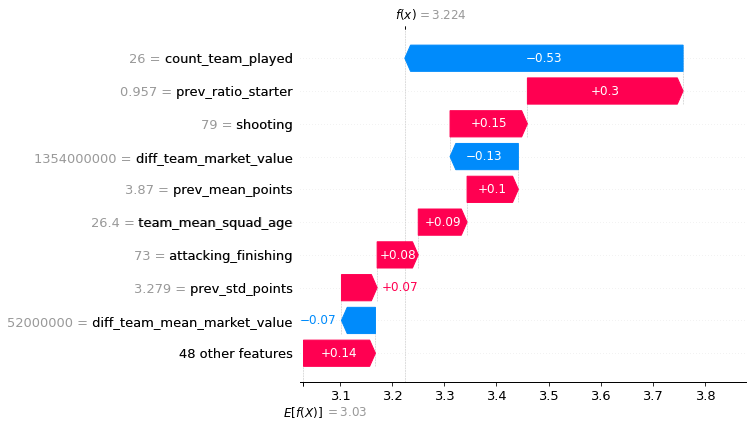

In [64]:
player_to_watch(shap_obj, test, "Ruslan Malinovskiy")

## Forward

In [65]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency
0,Romelu Lukaku,Belgium,Denmark,F,11.0,0.609800,5.754291,2.805361,10.0,13.0,7.529412,3.223307,0.470588
4,Harry Kane,England,Scotland,F,11.5,0.465239,4.728234,1.723122,2.0,17.0,5.333333,4.497987,0.458333
12,Artem Dzyuba,Russia,Finland,F,8.5,0.448769,3.917678,0.917846,2.0,19.0,5.304348,4.865788,0.434783
14,Cristiano Ronaldo,Portugal,Germany,F,12.0,0.488436,3.586241,0.612149,10.0,18.0,5.950000,5.020746,0.500000
15,Memphis Depay,Netherlands,Austria,F,10.0,0.365516,3.429139,0.395228,2.0,16.0,5.520000,3.820122,0.280000
24,Marcus Berg,Sweden,Slovakia,F,8.5,0.334545,2.960252,-0.081502,2.0,9.0,2.913043,2.130152,0.391304
25,Gareth Bale,Wales,Turkey,F,9.5,0.502829,2.820348,-0.133532,2.0,9.0,3.285714,2.411283,0.238095
33,Álvaro Morata,Spain,Poland,F,9.0,0.295410,2.050875,-0.995451,2.0,10.0,3.235294,2.634611,0.352941


Evaluating points for:  Harry Kane


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
207,Harry Kane,2021-06-18 21:00:00,European Championship 2020,England,Scotland,NaN,NaN,F,2021,6,18,NaN,11.5,4.0,2.0,0.0,0.0,5.333333,0.0,0.375,17.0,4.497987,0.875388,0.76967,90.0,0.875,24.0,0.458333,0.25,0.458333,28.0,NaN,NaN,NaN,0.857143,4,4,1686,31,44,1441,3.0,0.0,1.0,11.0,5.0,3.0,25.4,1.250000e+10,498000000.0,27.3,2.698500e+09,103800000.0,26.0,188.0,89.0,1.0,88.0,89.0,220000.0,3.0,68.0,91.0,80.0,80.0,47.0,ST,9.0,83.0,75.0,94.0,85.0,81.0,85.0,80.0,80.0,68.0,83.0,84.0,66.0,69.0,69.0,90.0,73.0,91.0,79.0,84.0,84.0,86.0,81.0,35.0,93.0,83.0,90.0,91.0,36.0,38.0,8.0,10.0,11.0,14.0,11.0,245,-40,9.801500e+09,394200000.0,-1.9,True,True,1.0,NaN,True,High,High,0.465239,4.728234


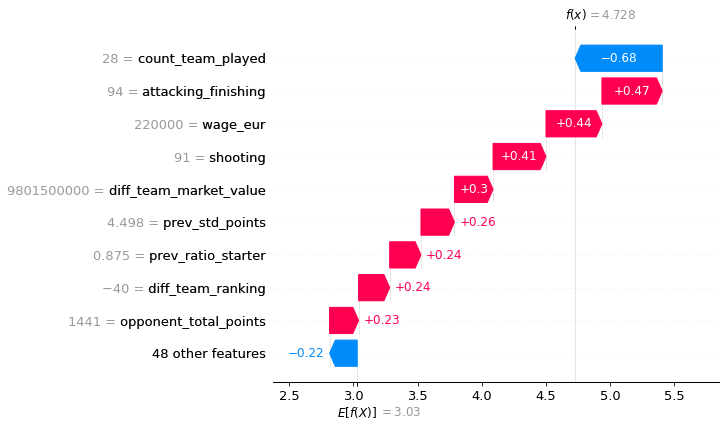

In [66]:
player_to_watch(shap_obj, test, "Harry Kane")

Evaluating points for:  Artem Dzyuba


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
51,Artem Dzyuba,2021-06-16 15:00:00,European Championship 2020,Russia,Finland,NaN,NaN,F,2021,6,16,NaN,8.5,4.0,2.0,0.0,0.0,5.304348,0.0,0.304348,19.0,4.865788,1.027295,0.558796,90.0,1.0,23.0,0.391304,0.26087,0.434783,28.0,NaN,NaN,NaN,0.821429,32,38,1462,54,54,1410,0.0,0.0,0.0,0.0,0.0,NaN,27.9,1.908000e+09,73400000.0,28.0,446000000.0,17200000.0,31.0,196.0,91.0,NaN,79.0,79.0,0.0,2.0,68.0,78.0,69.0,71.0,29.0,ST,22.0,85.0,61.0,81.0,87.0,77.0,74.0,73.0,66.0,60.0,57.0,77.0,67.0,69.0,55.0,75.0,35.0,80.0,65.0,78.0,93.0,69.0,80.0,30.0,81.0,77.0,83.0,79.0,17.0,21.0,15.0,12.0,11.0,11.0,8.0,52,-16,1.462000e+09,56200000.0,-0.1,True,True,0.0,NaN,False,Medium,Low,0.448769,3.917678


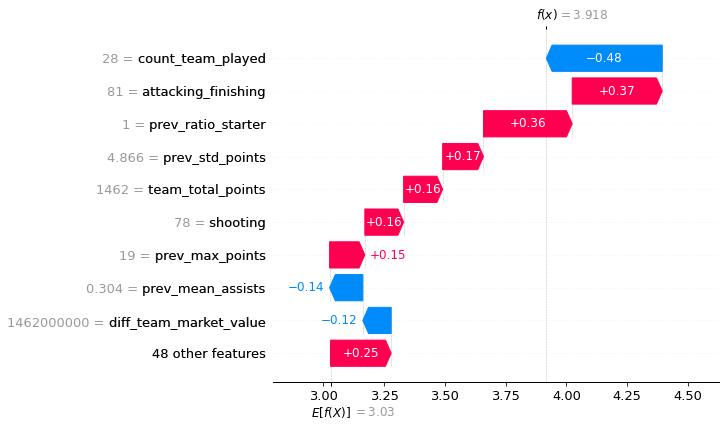

In [49]:
player_to_watch(shap_obj, test, "Artem Dzyuba")